> ### EEE4423: Deep Learning Lab

# LAB \#4: Limitation: Spatial Transformer Network(STN)

<h4><div style="text-align: right"> Due date: April 1, 2022.  </div> <br>
<div style="text-align: right"> Please upload your file @ LearnUs by 9 AM in the form of [ID_Name_Lab04.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span> 
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">[2018142102] [Euijin Hong]</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2023-03-28 04:39:21.531333


## Spatial Transformer Network for classification of distorted MNIST dataset

## Spatial Transformer Network(STN) [1]
>- CNNs are limited by the lack of ability to be spatially invariant to the input data
>- Learnable module which explicitly allows the spatial manipulation of data within the network
>- This differentiable module can be inserted into existing convolutional architectures

<img src="http://drive.google.com/uc?export=view&id=1GV2Ix6wuikWdq6-tGkZv2vMQbqMokDbf" alt="no_image" style="width: 900px;"/>

### STN module
>1. Localization Network
>>- With given input feature map, this network outputs the parameters of the spatial transformation (e.g. 6 parameters for affine transformation)
>>- Reference for affine transformation : [2],[3] <br>
>> <img src="http://drive.google.com/uc?export=view&id=1qho08Gzea5qDTpmsnii0rvwiLzwy54K6" alt="no_image" style="width: 900px;"/>

>2. Parameterised sampling grid (Grid generator)
>>- Set of points where the input feature map is sampled to produce the transformation which is a output of localization network  
>>- Target coordinate and source coordinate are normalised ($ -1\le(x_i^t, y_i^t)\le1$,$ -1\le(x_i^s, y_i^s)\le1$ )
<img src="http://drive.google.com/uc?export=view&id=1pRWzwevo1KjWi3WIC4K8SCkK4oYCD7FZ" alt="no_image" style="width: 500px;"/>
>3. Differentiable Image Sampling (Sampler)
>>- Ouput feature map is produced by differentiable bilinear interpolation with input feature map and parameterised sampling grid
    
<img src="http://drive.google.com/uc?export=view&id=1EjoZ6CVLTD3QNl1CKbg1w3YiNf1CzOmH" alt="no_image" style="width: 900px;"/>


In [2]:
import warnings
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.utils as v_utils
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import io
import requests
import os 
import copy
import time
%matplotlib inline

warnings.filterwarnings("ignore")

In [3]:
device0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'NVIDIA A100-SXM4-40GB'

In [4]:
# parameters

batch_size = 256
learning_rate = 0.001
num_epoch = 60
num_classes = 10

### 1. Dataset (Distorted MNIST, details in Appendix A.4 Distorted MNIST) [1point]
>- Generate RTS(rotated, translated, scaled) MNIST 
>>- Use *torchvision.transforms*
>>- Randomly rotating between $-45^\circ, 45^\circ$
>>- Randomly scaling the digit by a factor of between $0.7,1.2$
>>- Placing the digit in a random location in a $40\times40$ region of image's center
>>- Zerp padding to increase image's size for the digit's translation ($80\times80$ image)
>>- Images to tensor 
>>- Normalize data with MNIST dataset's mean and standard deviation printed in the 5th cell below


#### 1.1 Write codes for dataset's transformation [1 point]


In [16]:
print('STEP 1: DEFINE DATASET')

train_dataset = dset.MNIST(root='../dataset/lab04/MNIST', train=True, 
                        #############
                        # CODE HERE #
                        #############
                        transform = transforms.Compose([
                            transforms.ToTensor(),
                            # zero-padding image to resize to 80x80
                            transforms.Pad(26),
                            # random rotate(-45, 45), scale(0.7, 1.2), translate(-20<x<20, -20<y<20) 
                            transforms.RandomAffine((-45, 45), translate=(0.25, 0.25), scale=(0.7, 1.2)),
                            # normalize image with mean=0.1307 and std=0.3081
                            transforms.Normalize((0.1307,), (0.3081,))
                        ]),
                        target_transform=None,
                        download=True)
test_dataset = dset.MNIST(root='../dataset/lab04/MNIST', train=False, 
                        #############
                        # CODE HERE #
                        #############
                        transform = transforms.Compose([
                            transforms.ToTensor(),
                            # zero-padding image to resize to 80x80
                            transforms.Pad(26),
                            # random rotate(-45, 45), scale(0.7, 1.2), translate(-20<x<20, -20<y<20) 
                            transforms.RandomAffine((-45, 45), translate=(0.25, 0.25), scale=(0.7, 1.2)),
                            # normalize image with mean=0.1307 and std=0.3081
                            transforms.Normalize((0.1307,), (0.3081,))
                        ]),
                        target_transform=None,
                        download=False)


train_size = len(train_dataset)
test_size = len(test_dataset)

#dataset mean and std for normalization
print('MNIST mean: ',train_dataset.train_data.float().mean()/255)
print('MNIST std: ',train_dataset.train_data.float().std()/255)

STEP 1: DEFINE DATASET
MNIST mean:  tensor(0.1307)
MNIST std:  tensor(0.3081)


In [17]:
print('Train dataset size: {}'.format(len(train_dataset)))
print('Test dataset size: {}'.format(len(test_dataset)))

Train dataset size: 60000
Test dataset size: 10000


###  Visualize Dataset


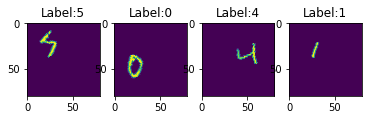

In [18]:
figure = plt.figure()

for i in range(train_size):
    sample = train_dataset[i]
    figure.add_subplot(1,4,i+1).set_title('Label:{}'.format(sample[1]))
    imgplot = plt.imshow((sample[0].squeeze(0).cpu()+1)/2)
    if i == 3:
        plt.show()
        break

In [19]:
print('STEP 2: LOADING DATASET')

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True,num_workers=4,drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size, shuffle=False,num_workers=4,drop_last=True)

STEP 2: LOADING DATASET


##  Model
### 2. CNN Model Setup (details in Appendix A.4 Distorted MNIST) [3points]
>
>1. CNN 
>>- 2 convolutional layers and 2 max-pooling layers before final classification layer
>>- Two conv layers have 32 and 64 filters and use ReLU 
>2. Classifier
>>- 2 fully-connected layers and the number of input features to the last layer is 128
>>- Also use ReLU as an activation function
>3. ST module
>>- At the beginning of the network
>>- 2 convolutional layer and 2 fully-connected layer in localization network
>>- Initialize the *fc_loc*'s final regression layer with identity transformation
>>- Produce affine transformation parameters for RTS dataset
>>- Reference for grid generator function: [4] <br>
>>- Reference for sampler function: [5] <br>
>
> **++Hint: All learnable parameters' sizes of model are in the 10th cell below** <br>
> **++For RTS datasets, the network has average pooling layer after the ST module to downsample the output of the transformer by a factor of 2**

| **Layer** | **Kernel size** | **stride** | **padding** |
|:---:|:---:|:---:|:---:|
| 1st Conv of *cnn* | 9 | 1 | 0 |
| 2nd Conv of *cnn* | 7 | 1 | 0 |
| 1st Conv of *localization* | 5 | 1 | 0 |
| 2nd Conv of *localization* | 5 | 1 | 0 |
| AvgPool | 2 | 2 | 0 |
| MaxPool | 2 | 2 | 0 |


#### 2.1 Write codes for the model class (STN_CNN) [3 points]


In [32]:
print('STEP 3: CREATE MODEL CLASS (STN_CNN)')


class STN_CNN(nn.Module):
    
#############
# CODE HERE #
#############

  def __init__(self):
    super(STN_CNN, self).__init__()
    
    # define CNN module
    self.cnn = nn.Sequential(
      nn.AvgPool2d(2, stride=2),
      nn.Conv2d(1, 32, kernel_size=9, stride=1, padding=0),
      nn.MaxPool2d(2, stride=2),
      nn.ReLU(True),
      nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=0),
      nn.MaxPool2d(2, stride=2),
      nn.ReLU(True)
    )

    # define FC classifier module
    self.classifier = nn.Sequential(
      nn.Linear(1600, 128),
      nn.ReLU(True),
      nn.Linear(128, 10)
    )

    # define spatial transformer localization-network
    self.localization = nn.Sequential(
      nn.Conv2d(1, 20, kernel_size=5),
      nn.MaxPool2d(2, stride=2),
      nn.ReLU(True),
      nn.Conv2d(20, 20, kernel_size=5),
      nn.ReLU(True)
    )

    # define regressor for the 3 * 2 affine matrix
    self.fc_loc = nn.Sequential(
      nn.Linear(23120, 20),  # 23120 = 34 * 34 * 20
      nn.ReLU(True),
      nn.Linear(20, 3 * 2)  # output = 3 * 2 affine matrix
    )

    # initialize the weights to zero and biases to identity transformation, with no autograd
    with torch.no_grad():
      self.fc_loc[2].weight.data.zero_()
      self.fc_loc[2].bias.data = nn.parameter.Parameter(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

  # define forward pass of STN to transform the input
  def STN(self, x):
    xs = self.localization(x)
    xs = xs.view(-1, 23120)
    th = self.fc_loc(xs)
    th = th.view(-1, 2, 3)

    grid = F.affine_grid(th, x.size())
    x = F.grid_sample(x, grid)
    return x

  # define the overall forward propagation of the STN_CNN model
  def forward(self, x):
    # spatial transformation of the input
    x = self.STN(x)

    # apply forward propagation to regular CNN network
    x = self.cnn(x)
    x = x.view(-1, 1600)
    x = self.classifier(x)
    
    return F.softmax(x, dim=1)

STEP 3: CREATE MODEL CLASS (STN_CNN)


In [33]:
print('STEP 4: INSTANTIATE MODEL CLASS\n')
model = STN_CNN()

print("STN_CNN's state_dict:")
os.makedirs('weights/lab04', exist_ok=True)
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

STEP 4: INSTANTIATE MODEL CLASS

False
False
STN_CNN's state_dict:
cnn.1.weight 	 torch.Size([32, 1, 9, 9])
cnn.1.bias 	 torch.Size([32])
cnn.4.weight 	 torch.Size([64, 32, 7, 7])
cnn.4.bias 	 torch.Size([64])
classifier.0.weight 	 torch.Size([128, 1600])
classifier.0.bias 	 torch.Size([128])
classifier.2.weight 	 torch.Size([10, 128])
classifier.2.bias 	 torch.Size([10])
localization.0.weight 	 torch.Size([20, 1, 5, 5])
localization.0.bias 	 torch.Size([20])
localization.3.weight 	 torch.Size([20, 20, 5, 5])
localization.3.bias 	 torch.Size([20])
fc_loc.0.weight 	 torch.Size([20, 23120])
fc_loc.0.bias 	 torch.Size([20])
fc_loc.2.weight 	 torch.Size([6, 20])
fc_loc.2.bias 	 torch.Size([6])


###  Parameter updates
#### Scheduling (Annealing) the learning rate [6]
>- In training deep networks, it is usually helpful to anneal the learning rate over time
>>- With high learning rate, the optimizing system can't settle down into deeper parts of the loss function
>- When to decay can be tricky
>>- Slowly : Wasting computation with little improvement for a long time
>>- Aggressively: Cooling too quickly, unable to find the best point
>- 3 common types
>>1. Step decay: Reduce the learning rate by some factor every few epochs (e.g. half every 5 epochs, or by 0.1 every 10 epochs)
>>2. Exponential decay: In the form of mathematical formulation $\alpha = \alpha_0\exp^{-kt}$, where $\alpha_0, k$ are hyperparameters and $t$ is the iteration number(or units of epochs)
>>3. $1/t$ decay : In the form of mathematical formulation $\alpha = \alpha_0/(1+kt)$, where $\alpha_0, k$ are hyperparameters and $t$ is the iteration number
>- In practice, the step decay is slightly preferable

#### How to adjust learning rate in pytorch [7]
>- *torch.optim.lr_scheduler* provides several methods based on the number of epochs
>- For example, the step decay can be implemented by *torch.optim.lr_scheduler.StepLR* class (See reference for more types)
>- We use *ReduceLROnPlateau* class in this lab which allows dynamic learning rate adjusting based on our validation measurements
>>- Reduce the learning rate when our metric has stopped improving 
>>- The learning rate is reduced if no improvement of our metric is seen for a 'patience' number of epochs
>>- See reference for more details 


In [23]:
print('STEP 5: INSTANTIATE OPTIMIZER CLASS')

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor = 0.1, patience=6)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

STEP 5: INSTANTIATE OPTIMIZER CLASS


### 3.Train/Test [2points]


#### 3.1Tirain the STN_CNN model and print accuracy for every epochs [2 points]


In [24]:
print('STEP 6: INSTANTIATE LOSS CLASS')
#############
# CODE HERE #
#############

# using CrossEntropyLoss function to evaluate loss
criterion = nn.CrossEntropyLoss()

# Model to GPU
model.to(device0)

print('STEP 7: TRAIN THE MODEL')
best_acc = 0
num_epoch = 60

for epoch in range(num_epoch):
    #TRAIN
    model.train()
    start = time.time()
    correct = 0
    
    for j,(img,label) in enumerate(train_loader):
        
        #############
        # CODE HERE #
        #############

        # use GPU for images, labels
        x = img.to(device0)
        y = label.to(device0)

        # clear gradients with respect to parameters
        optimizer.zero_grad()

        # Forward propagation of model
        outputs = model(x)

        # Evaluating loss
        loss = criterion(outputs, y)
        
        # get gradients with respect to parameters
        loss.backward()

        # update parameters
        optimizer.step()

        if j % 200 == 0:
            
            print('Train Epoch: {} [{}/{} ({:.0f}%) / Learning rate:{}]\tLoss:{:.6f}  '.format(
                    epoch, j * len(img), train_size,
                    100. * j / len(train_loader),get_lr(optimizer), loss.item()))
            
           
                    
    #Test
    model.eval()
    #############
    # CODE HERE #
    #############
    for img, label in test_loader:
      # use GPU for images, labels
      x = img.to(device0)
      y = label.to(device0)

      # Forward propagation of model
      outputs = model(x)

      # get prediction 
      _, predicted = torch.max(outputs.data, 1)

      # sum up correct number of predicted labels
      if torch.cuda.is_available():
        correct += (predicted.cpu() == y.cpu()).sum()
      else:
        correct += (predicted == y).sum()

    # calculate and print the test accuracy of this epoch
    accuracy = correct.item() / 10000 * 100
    print(f'Test set accuracy: {correct.item()}/10000 ({accuracy}%)')
    print('////Epoch elapsed time: {}////\n'.format(time.time() - start))  
    
    # updating the best accuracy and save the best weight model
    if accuracy > best_acc :
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'accuracy': accuracy
            
            }, './weights/lab04/best_model_STN.tar')
       
        best_acc = accuracy
    
    scheduler.step(accuracy)

STEP 6: INSTANTIATE LOSS CLASS
STEP 7: TRAIN THE MODEL
Train Epoch: 0 [0/60000 (0%) / Learning rate:0.001]	Loss:2.301746  
Train Epoch: 0 [51200/60000 (85%) / Learning rate:0.001]	Loss:1.934546  
Test set accuracy: 5726/10000 (57.26%)
////Epoch elapsed time: 19.5128173828125////

Train Epoch: 1 [0/60000 (0%) / Learning rate:0.001]	Loss:1.892667  
Train Epoch: 1 [51200/60000 (85%) / Learning rate:0.001]	Loss:1.673189  
Test set accuracy: 8134/10000 (81.34%)
////Epoch elapsed time: 17.36518621444702////

Train Epoch: 2 [0/60000 (0%) / Learning rate:0.001]	Loss:1.689139  
Train Epoch: 2 [51200/60000 (85%) / Learning rate:0.001]	Loss:1.605300  
Test set accuracy: 8504/10000 (85.04%)
////Epoch elapsed time: 17.433297157287598////

Train Epoch: 3 [0/60000 (0%) / Learning rate:0.001]	Loss:1.642036  
Train Epoch: 3 [51200/60000 (85%) / Learning rate:0.001]	Loss:1.583152  
Test set accuracy: 8961/10000 (89.61%)
////Epoch elapsed time: 17.401267051696777////

Train Epoch: 4 [0/60000 (0%) / Learn

### 4. Visualize original inputs and transformed inputs with best pre-trained model  [3points]


In [25]:
model = STN_CNN()
checkpoint = torch.load('./weights/lab04/best_model_STN.tar')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

#### Our pretrained model's best accuracy


In [26]:
print('Best accuracy of our model with ST module: ', checkpoint['accuracy'])

Best accuracy of our model with ST module:  98.2


In [27]:
# Tensor image to array image
def reprocess_image(img):
    
    img_re = copy.copy(img.cpu().data.numpy())
    
    mean = [-0.1307,-0.1307,-0.1307]
    std = [1/0.3081,1/0.3081,1/0.3081]
    
    for c in range(3):
        img_re[c,:,:] /= std[c]
        img_re[c,:,:] -= mean[c]
        
    img_re[img_re > 1] = 1
    img_re[img_re < 0] = 0
    
    img_re = img_re.transpose(1,2,0)
    
    return img_re

#### 4.1 Write codes for visualization of original inputsa and transformed inputs [3 points]
>- VisualizeSTN class with an input of our pretrained model
>- *forward_stn*: Forward pass of our pretrained STN module to produce transformed inputs
>- *visualize*: Visualizing the original inputs and the transformed ones in a grid 
>>1. Forward pass of STN module to produce the transformed inputs
>>2. Unnormalize both images using *reprocess_image* function
>>3. Make grids of them 
>>4. Visualize 


In [28]:
class VisualizeSTN():
    
    def __init__(self, model):
        self.model = model
        self.model.to(device0)
        self.model.eval()
    
    # Output transformed inputs
    def forward_stn(self,x):
        #############
        # CODE HERE #
        #############
      x = self.model.STN(x)
      return x

    def visualize(self, img):
        #############
        # CODE HERE #
        #############

      # no auto gradient tracking while inference
      with torch.no_grad():
        # original input images tensor to CPU
        input = img.cpu()
        # transformed input images tensor to CPU
        transformed_input = self.forward_stn(img).cpu()

        # create grids of input(original) and output(transformed) images
        in_grid = reprocess_image(
            v_utils.make_grid(input, nrow = 4))  # select number of grid rows to 4
        out_grid = reprocess_image(
            v_utils.make_grid(transformed_input, nrow = 4))  # select number of grid rows to 4
        
        # plot the subplot of grids: original and transformed images
        f, subplot = plt.subplots(1, 2)
        subplot[0].imshow(in_grid)
        subplot[0].set_title('Original Images')
        subplot[1].imshow(out_grid)
        subplot[1].set_title('Transformed Images')
        
      plt.ioff()
      plt.show()

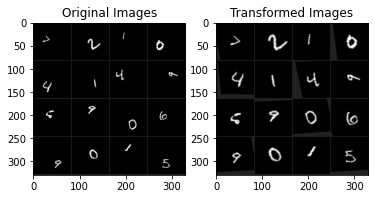

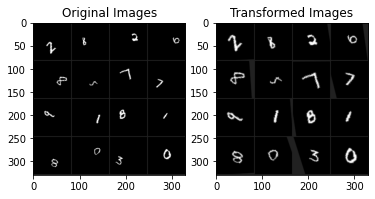

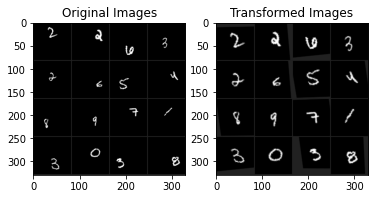

In [29]:
visualize_stn = VisualizeSTN(model)
for i, (image,label) in enumerate(test_loader):
    img = image[:16].to(device0)
    visualize_stn.visualize(img)
    
    if (i+1) == 3:
        break

### 5.Comparison with the cnn model without ST module [1point]
>- Model composed of cnn and classifier modules same with our pretrained CNN_STN model 
>- Use *cnn* and *classifier* modules you implemented 


#### 5.1 Write codes for the model class

In [116]:
#############
# CODE HERE #
#############
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    # define CNN module
    self.cnn = nn.Sequential(
      nn.AvgPool2d(2, stride=2),
      nn.Conv2d(1, 32, kernel_size=9, stride=1, padding=0),
      nn.MaxPool2d(2, stride=2),
      nn.ReLU(True),
      nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=0),
      nn.MaxPool2d(2, stride=2),
      nn.ReLU(True)
    )

    # define FC classifier module
    self.classifier = nn.Sequential(
      nn.Linear(1600, 128),
      nn.ReLU(True),
      nn.Linear(128, 10)
    )

  # define overall forward pass of CNN model
  def forward(self, x):
    # apply forward propagation
    x = self.cnn(x)
    x = x.view(-1, 1600)
    x = self.classifier(x)
    
    return F.softmax(x, dim=1)

In [117]:
model_nostn = CNN()

print("CNN's state_dict:")
for param_tensor in model_nostn.state_dict():
    print(param_tensor, "\t", model_nostn.state_dict()[param_tensor].size())

CNN's state_dict:
cnn.1.weight 	 torch.Size([32, 1, 9, 9])
cnn.1.bias 	 torch.Size([32])
cnn.4.weight 	 torch.Size([64, 32, 7, 7])
cnn.4.bias 	 torch.Size([64])
classifier.0.weight 	 torch.Size([128, 1600])
classifier.0.bias 	 torch.Size([128])
classifier.2.weight 	 torch.Size([10, 128])
classifier.2.bias 	 torch.Size([10])


In [118]:
optimizer = torch.optim.Adam(model_nostn.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor = 0.1, patience=6)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

#### 5.2 Train/Test

In [119]:
print('STEP 6: INSTANTIATE LOSS CLASS')
#############
# CODE HERE #
#############

# using CrossEntropyLoss function to evaluate loss
criterion = nn.CrossEntropyLoss()

# Model to GPU
model_nostn.to(device0)


print('STEP 7: TRAIN THE MODEL')
best_acc = 0
num_epoch = 60

for epoch in range(num_epoch):
    #TRAIN
    model_nostn.train()
    start = time.time()
    correct = 0
    
    for j,(img,label) in enumerate(train_loader):
        
        #############
        # CODE HERE #
        #############

        # use GPU for images, labels
        x = img.to(device0)
        y = label.to(device0)

        # clear gradients with respect to parameters
        optimizer.zero_grad()

        # Forward propagation of model
        outputs = model_nostn(x)

        # Evaluating loss
        loss = criterion(outputs, y)

        # get gradients with respect to parameters
        loss.backward()

        # update parameters
        optimizer.step()

        if j % 200 == 0:
            
            print('Train Epoch: {} [{}/{} ({:.0f}%) / Learning rate:{}]\tLoss:{:.6f}  '.format(
                    epoch, j * len(img), train_size,
                    100. * j / len(train_loader),get_lr(optimizer), loss.item()))
            
           
                    
    #Test
    model_nostn.eval()
    #############
    # CODE HERE #
    #############
    for img, label in test_loader:
      # use GPU for images, labels
      x = img.to(device0)
      y = label.to(device0)

      # Forward propagation of model
      outputs = model_nostn(x)

      # get prediction 
      _, predicted = torch.max(outputs.data, 1)

      # sum up correct number of predicted labels
      if torch.cuda.is_available():
        correct += (predicted.cpu() == y.cpu()).sum()
      else:
        correct += (predicted == y).sum()

    # calculate and print the test accuracy of this epoch
    accuracy = correct.item() / 10000 * 100
    print(f'Test set accuracy: {correct.item()}/10000 ({accuracy}%)')
    print('////Epoch elapsed time: {}////\n'.format(time.time() - start))  
    
    # updating the best accuracy
    if accuracy > best_acc :
        best_acc = accuracy
    
    scheduler.step(accuracy)

STEP 6: INSTANTIATE LOSS CLASS
STEP 7: TRAIN THE MODEL
Train Epoch: 0 [0/60000 (0%) / Learning rate:0.001]	Loss:2.301955  
Train Epoch: 0 [51200/60000 (85%) / Learning rate:0.001]	Loss:2.111056  
Test set accuracy: 4378/10000 (43.78%)
////Epoch elapsed time: 17.565263748168945////

Train Epoch: 1 [0/60000 (0%) / Learning rate:0.001]	Loss:2.061317  
Train Epoch: 1 [51200/60000 (85%) / Learning rate:0.001]	Loss:1.814774  
Test set accuracy: 6689/10000 (66.89%)
////Epoch elapsed time: 17.75007200241089////

Train Epoch: 2 [0/60000 (0%) / Learning rate:0.001]	Loss:1.786275  
Train Epoch: 2 [51200/60000 (85%) / Learning rate:0.001]	Loss:1.716251  
Test set accuracy: 7273/10000 (72.72999999999999%)
////Epoch elapsed time: 17.599939823150635////

Train Epoch: 3 [0/60000 (0%) / Learning rate:0.001]	Loss:1.743196  
Train Epoch: 3 [51200/60000 (85%) / Learning rate:0.001]	Loss:1.685829  
Test set accuracy: 7589/10000 (75.89%)
////Epoch elapsed time: 17.6587917804718////

Train Epoch: 4 [0/60000 

#### Best accuracy of the model without ST module


In [120]:
print('Best accuracy of our model without ST module: ', best_acc)

Best accuracy of our model without ST module:  96.23


### *References*
[1] https://arxiv.org/pdf/1506.02025.pdf <br>
[2] https://en.wikipedia.org/wiki/Affine_transformation <br>
[3] https://en.wikipedia.org/wiki/Transformation_matrix#Affine_transformations <br>
[4] https://pytorch.org/docs/stable/nn.html#affine-grid <br>
[5] https://pytorch.org/docs/stable/nn.html#torch.nn.functional.grid_sample <br>
[6] http://cs231n.github.io/neural-networks-3/#anneal <br>
[7] https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate <br>

#Discussion

- STN을 CNN에 적용한 모델과 그렇지 않은 모델 간의 성능을 비교했을 때, test set에서 최대 accuracy가 각각 98.2%, 96.23%로, STN을 적용한 모델이 그렇지 않은 모델보다 1.97% 뛰어난 성능을 보였다. 이때, STN의 적용 유무 이외의 모든 조건들(CNN model의 구조, hyperparameters, dataset 등)은 동일하게 주어졌다.
- 이는 STN을 적용시킨 모델에서 CNN에 들어가는 input이 위에서 visualize한 것처럼, 원래 무작위로 변형되어 주어진 MNIST input data들을 STN을 통해 CNN이 학습하기 더 유리한 형태로 transform시켰기 때문이라고 할 수 있다. 
- STN을 적용시킨 network와 그렇지 않은 모델을 비교했을 때, 한 epoch당 경과한 시간은 STN을 적용시킨 모델이 평균적으로 약 0.2초 정도 더 짧은 것으로 나타난다. 
- 이러한 결과는 논문에도 언급되어 있듯이, STN에서 요구하는 행렬 연산 자체의 연산량도 크지 않을 뿐더러, STN을 통해 생성된 transform된 input은 CNN이 학습하기 용이한 feature들을 뽑아 downsample된 형태이기 때문에 이후 CNN에서 학습될 때 연산 및 처리되는 속도가 더 빠르게 나타난 것으로 보인다. 
- STN은 CNN과 합쳐졌음에도 하나의 연결된 모듈로서 backward propagation을 통해 end-to-end training이 가능했다. 이는 STN의 각각의 layer들과 그 안의 parameter들이 미분 가능한 형태이기 때문이다. 따라서, 이후 CNN이 학습하기 좋은 형태로 transform하는 최적의 방법을 backward propagation을 통해 학습한다. 